## What is in the notebook:

This notebook gathers together state maternal mortality data, health-insurance data, and income data for states between 2010-2019. It also gathers together various natility data from 2010-2019.

In [346]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import copy

### Loading Data

#### CDC Maternal mortality data

In [347]:
maternal_mortality_df = pd.read_csv("..\\data\\cdc_data\\all_states_all_codes_by_year.csv")
maternal_mortality_df = maternal_mortality_df[["State", "Year", "Deaths", "Population"]]
print(maternal_mortality_df[maternal_mortality_df.Year>=1995])



              State  Year  Deaths  Population
0           Alabama  1999      10     1801848
1           Alabama  2005      12     1856905
2           Alabama  2006      10     1880993
3           Alabama  2015      12     1929191
4           Alabama  2016      35     1920571
...             ...   ...     ...         ...
1197        Vermont  1995       0      300279
1198        Vermont  1996       0      303034
1199        Vermont  1997       0      304893
1220     Washington  1995       0     2757505
1231  West Virginia  1995       0      941762

[631 rows x 4 columns]


#### ACS Income Data

This data frame needs to be pivoted.

In [348]:
income_df = pd.read_csv("..\\data\\acs_income_by_year\\all_income_from_2010_to_2023.csv")
income_df = income_df[income_df.columns[1:]]
income_df_pivot = pd.pivot(data = income_df,  index ='Year', columns= 'label')
income_df = income_df_pivot.stack(level=0)
income_df.reset_index(inplace=True)
income_df.rename(columns = {"level_1" : "State"},inplace= True)
income_df.head()




C:\Users\david\AppData\Local\Temp\ipykernel_14332\560642248.py:4: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  income_df = income_df_pivot.stack(level=0)


label,Year,State,"$10,000 to $14,999","$100,000 to $149,999","$15,000 to $24,999","$150,000 to $199,999","$200,000 or more","$25,000 to $34,999","$35,000 to $49,999","$50,000 to $74,999","$75,000 to $99,999","Less than $10,000",Total
0,2010,Alabama,291136,462295,568262,155190,110550,515050,683128,805464,487371,418610,4499250
1,2010,Alaska,24791,122561,46620,45879,36225,52474,73631,121399,89373,23792,637189
2,2010,Arizona,301174,694479,620656,213517,196895,663570,884336,1119302,695469,414482,5802329
3,2010,Arkansas,186755,243784,379359,68553,56348,371449,442926,508686,289906,236611,2784750
4,2010,California,1486323,4692266,2969203,2048096,2047855,2756878,3942244,5360641,3913537,1690857,30895516


Here we aggregate the income data. Change the boolean ```Agg_Income``` to ```False``` if you do not want to aggregate income.

In [349]:
Agg_Income = False
if Agg_Income:
    income_df['sub_75k_income'] = income_df["Less than $10,000"]+income_df["$10,000 to $14,999"]+income_df["$15,000 to $24,999"]+income_df["$25,000 to $34,999"]+income_df["$35,000 to $49,999"]+income_df["$50,000 to $74,999"]
    income_df['between_75k_150k_income'] = income_df['$75,000 to $99,999']+income_df["$100,000 to $149,999"]
    income_df['above_150k_income'] = income_df['$150,000 to $199,999']+income_df['$200,000 or more']
    income_df = income_df[["State","Year","sub_75k_income",  'between_75k_150k_income',"above_150k_income","Total"]]


#### Natality Data

In [350]:
natility_df = pd.read_csv("StateNatalityDF.csv")
print(f"Shape of dataframe with null values is {natility_df.shape}")
natility_df.dropna(inplace = True, axis = 1)
print(f"Shape of dataframe after droping columns that have null values is {natility_df.shape}")
natility_df.shape



Shape of dataframe with null values is (210, 41)
Shape of dataframe after droping columns that have null values is (210, 19)


(210, 19)

### Behavioral Data

In [351]:
with open('..\\data\\behavioral_data\\data\\all_states_behavior_data.pkl', 'rb') as file:
    behavior_df = pickle.load(file)
behavior_df.head()
behavior_df = behavior_df[["Year", "State", "Female_Population"	,"Percent_Overweight"	,"Percent_Obese",	"Percent_Overweight_or_Obese"	,"Percent_No_Activity"]]
behavior_df.dropna(inplace = True)
for c in behavior_df.columns:
    if "Percent" in c:
        s = c.replace("Percent","Absolute")
        behavior_df[s] = behavior_df[c]/100*behavior_df.Female_Population.astype("int")
behavior_df.head()
behavior_df.info()




<class 'pandas.core.frame.DataFrame'>
Index: 646 entries, 0 to 649
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Year                          646 non-null    int64  
 1   State                         646 non-null    object 
 2   Female_Population             646 non-null    object 
 3   Percent_Overweight            646 non-null    float64
 4   Percent_Obese                 646 non-null    float64
 5   Percent_Overweight_or_Obese   646 non-null    float64
 6   Percent_No_Activity           646 non-null    float64
 7   Absolute_Overweight           646 non-null    float64
 8   Absolute_Obese                646 non-null    float64
 9   Absolute_Overweight_or_Obese  646 non-null    float64
 10  Absolute_No_Activity          646 non-null    float64
dtypes: float64(8), int64(1), object(2)
memory usage: 60.6+ KB


#### Merging Data Sets (No Scaling)

Here we merge the data sets. Since this is dealing with absolute numbers, I'ved dropped the "Percent" columns in the ```behavior_df``` dataframe.
The natality data is currently commented out. To include that uncomment.


In [466]:
merged_df = pd.merge(left = maternal_mortality_df, right = income_df, on = ["Year","State"], how = 'inner')
print(f"Maternal mortality and income data frame has size {merged_df.shape}.")
merged_df = pd.merge(left = merged_df, right = behavior_df[[c for c in behavior_df.columns if not "Percent" in c]], on =["Year", "State"], how = 'inner' )
print(f'Maternal mortality, income, and behavioral data frame has size {merged_df.shape}')
#merged_df = pd.merge(left = merged_df, right = natility_df, on = ["Year", "State"], how = 'inner')
#print(f"Maternal mortality, income, behavioral, and natality data frame has size {merged_df.shape}.")
merged_df.drop(columns = ["Total", "Population"], inplace = True)
merged_df.drop(columns = "Female_Population", inplace=True)
merged_df.info()


Maternal mortality and income data frame has size (293, 15).
Maternal mortality, income, and behavioral data frame has size (267, 20)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 267 entries, 0 to 266
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   State                         267 non-null    object 
 1   Year                          267 non-null    int64  
 2   Deaths                        267 non-null    int64  
 3   $10,000 to $14,999            267 non-null    int64  
 4   $100,000 to $149,999          267 non-null    int64  
 5   $15,000 to $24,999            267 non-null    int64  
 6   $150,000 to $199,999          267 non-null    int64  
 7   $200,000 or more              267 non-null    int64  
 8   $25,000 to $34,999            267 non-null    int64  
 9   $35,000 to $49,999            267 non-null    int64  
 10  $50,000 to $74,999            267 non-null    in

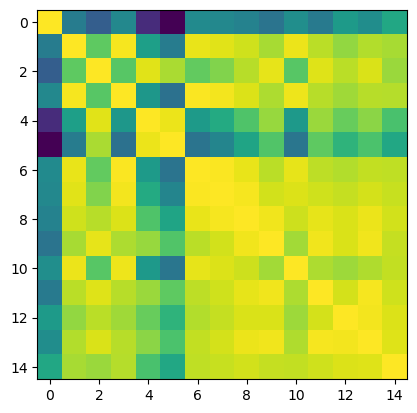

In [467]:
MergeDF_Corr = merged_df[merged_df.columns[2:]].corr(method = 'pearson')
plt.imshow(MergeDF_Corr)

In [468]:
MergeDF_Corr.sort_values("Deaths",ascending= False, inplace = True)
print(MergeDF_Corr.Deaths.head(20))

Deaths                          1.000000
Absolute_No_Activity            0.848163
Absolute_Obese                  0.826916
Less than $10,000               0.807466
Absolute_Overweight_or_Obese    0.805824
$25,000 to $34,999              0.801439
$15,000 to $24,999              0.797268
$35,000 to $49,999              0.796885
$50,000 to $74,999              0.789000
$10,000 to $14,999              0.779143
Absolute_Overweight             0.776854
$75,000 to $99,999              0.765965
$100,000 to $149,999            0.733907
$150,000 to $199,999            0.668694
$200,000 or more                0.620223
Name: Deaths, dtype: float64


In [470]:
merged_good = merged_df[merged_df.State.isin(list(merged_df.groupby("State").Year.count().reset_index()[merged_df.groupby("State").Year.count().reset_index().Year>=7].State.unique()))]
#sns.pairplot(merged_good, hue = "State", y_vars= 'Deaths', x_vars = merged_good.columns[2:])
print(merged_good.shape)

(223, 17)


In [463]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score
from sklearn.linear_model import Lasso, LinearRegression, PoissonRegressor, Ridge
from sklearn.feature_selection import RFE, RFECV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [464]:
merged_good.head()
y = merged_good.Deaths.values
X = merged_good[merged_good.columns[3:]].values
X_train, X_test , y_train, y_test = train_test_split(X,y, shuffle= True, test_size = .2, random_state= 12)
numerical_columns = merged_good.columns[3:]


### Feature Selection with RFE for Linear Model

In [465]:
### First do standard scaling:
stand_scaling = StandardScaler()
model = LinearRegression()
X_train_scale = stand_scaling.fit_transform(X_train)
cv_classes = 10
rfecv = RFECV(estimator = model, step = 1, cv = cv_classes)
rfecv.fit(X_train, y_train)
support = rfecv.support_
print(f"Number of features removed is {X_train_scale.shape[1]-np.sum(support*1)}.")
X_train_selected = X_train[:,support]
print(f"Number of remaing features is {X_train_selected.shape[1]}.")
print("\n")
print("The features deleted are:")
for (c,bo) in zip(numerical_columns,support):
    if not bo:
        print("\tFeature "+c+" is deleted.")
print("\n")
print("The features kept are:")
for (c,bo) in zip(numerical_columns,support):
    if bo:
        print("\tFeature "+c+" is kept.")

X_train_selected = X_train

Number of features removed is 7.
Number of remaing features is 24.


The features deleted are:
	Feature $50,000 to $74,999 is deleted.
	Feature $75,000 to $99,999 is deleted.
	Feature Absolute_Overweight is deleted.
	Feature Absolute_Obese is deleted.
	Feature Absolute_Overweight_or_Obese is deleted.
	Feature Absolute_No_Activity is deleted.
	Feature Unmarried is deleted.


The features kept are:
	Feature $10,000 to $14,999 is kept.
	Feature $100,000 to $149,999 is kept.
	Feature $15,000 to $24,999 is kept.
	Feature $150,000 to $199,999 is kept.
	Feature $200,000 or more is kept.
	Feature $25,000 to $34,999 is kept.
	Feature $35,000 to $49,999 is kept.
	Feature Less than $10,000 is kept.
	Feature Births is kept.
	Feature BirthCenterBirths is kept.
	Feature MD_Delivery is kept.
	Feature DO_Delivery is kept.
	Feature CNM_Delivery is kept.
	Feature Other_Delivery_Attendant is kept.
	Feature 3rdMonthInitialCare is kept.
	Feature 4thMonthInitialCare is kept.
	Feature 7thMonthInitialCare is 

Let's look at some of the variabiity for Linear Regression.

In [403]:
from sklearn.metrics import mean_squared_error

In [404]:
model = Pipeline([("scale", StandardScaler()), ("approx", LinearRegression())])
cv_classes = 20
cv_scores = cross_val_score(estimator=model, X = X_train_selected, y = y_train, cv = cv_classes)


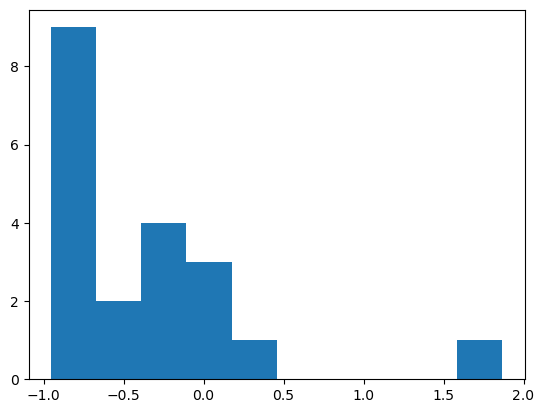

The average error for linear regression is -0.36.
The standard deviation for linear regression is 0.65.


In [405]:
plt.hist(-cv_scores)
plt.show()
print(f"The average error for linear regression is {np.round(-cv_scores.mean(),2)}.")
print(f"The standard deviation for linear regression is {np.round(cv_scores.std(),2)}.")


What about this for Poisson Regression.

In [ ]:
model = Pipeline([("scale", StandardScaler()), ("approx", PoissonRegressor())])
cv_classes = 20
cv_scores = cross_val_score(estimator=model, X = X_train_selected, y = y_train, cv = cv_classes)


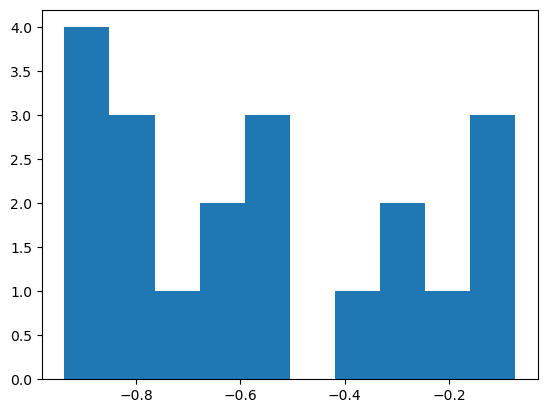

The average error for Poisson regression is -0.56.
The standard deviation for Poisson regression is 0.3.


In [407]:
plt.hist(-cv_scores)
plt.show()
print(f"The average error for Poisson regression is {np.round(-cv_scores.mean(),2)}.")
print(f"The standard deviation for Poisson regression is {np.round(cv_scores.std(),2)}.")

Both linear regression and Poisson regression seem to have large mean square errors.
Maybe we are overfitting the data? Let's try to use Lasso.

In [408]:
from sklearn.preprocessing import FunctionTransformer, QuantileTransformer
alpha_choices = [0, 1/10, 1/2, 1, 2, 5]
for alpha in alpha_choices:
    model = Pipeline([('log', FunctionTransformer(lambda x:np.log(1+np.sqrt(x)))),("scale", StandardScaler()), ("approx",Lasso(alpha = alpha))])
    cv_classes = 20
    cv_scores = cross_val_score(estimator=model, X = X_train_selected, y = y_train, cv = cv_classes)
    print(f"The average error for Lasso with alpha = {np.round(alpha,2)} is {np.round(-cv_scores.mean(),2)}.")
    print(f"The standard deviation for Lasso with alpha = {np.round(alpha,2)} is {np.round(cv_scores.std(),2)}.")
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_train_selected)



c:\Users\david\anaconda3\envs\erdos_spring_2025\Lib\site-packages\sklearn\base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\david\anaconda3\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\david\anaconda3\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.421e+04, tolerance: 1.510e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn

The average error for Lasso with alpha = 0 is -0.26.
The standard deviation for Lasso with alpha = 0 is 0.86.


c:\Users\david\anaconda3\envs\erdos_spring_2025\Lib\site-packages\sklearn\base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\david\anaconda3\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\david\anaconda3\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.510e+04, tolerance: 1.640e+01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn

The average error for Lasso with alpha = 0.1 is -0.29.
The standard deviation for Lasso with alpha = 0.1 is 0.87.
The average error for Lasso with alpha = 0.5 is -0.31.
The standard deviation for Lasso with alpha = 0.5 is 0.82.
The average error for Lasso with alpha = 1 is -0.32.
The standard deviation for Lasso with alpha = 1 is 0.77.
The average error for Lasso with alpha = 2 is -0.35.
The standard deviation for Lasso with alpha = 2 is 0.71.
The average error for Lasso with alpha = 5 is -0.4.
The standard deviation for Lasso with alpha = 5 is 0.54.


Maybe add some non-linear features?

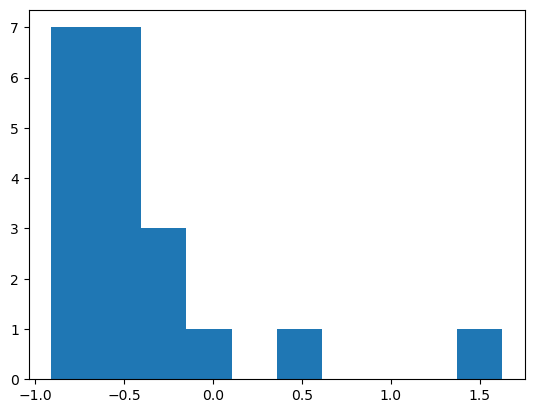

The average error for Lasso regression is -0.4.
The standard deviation for Lasso regression is 0.54.


In [410]:
plt.hist(-cv_scores)
plt.show()
print(f"The average error for Lasso regression is {np.round(-cv_scores.mean(),2)}.")
print(f"The standard deviation for Lasso regression is {np.round(cv_scores.std(),2)}.")

Let's now do cross-validation for various models.

The average mean square error is 10.55.
The standard deviation for this value is 5 is 2.73.


np.float64(280.9891694879694)

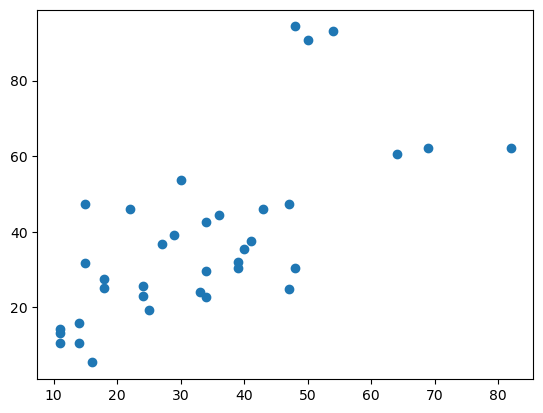

In [457]:
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures

model = Pipeline([('transform1', FunctionTransformer(lambda x: np.log(1+(x)))),
                  ('scale', StandardScaler()),
                ("transform2", PolynomialFeatures(degree = 2)),
                ("lin_model",Lasso(max_iter = 50000,alpha = .1))
            ])
cv_classes = 20
cv_scores = cross_val_score(estimator=model, X = X_train_selected, y = y_train, cv = cv_classes, scoring = 'neg_mean_absolute_error')
print(f"The average mean square error is {np.round(-cv_scores.mean(),2)}.")
print(f"The standard deviation for this value is {np.round(alpha,2)} is {np.round(cv_scores.std(),2)}.")


X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train_selected, y_train, test_size = .2)
model.fit(X_train_train, y_train_train)

y_pred = model.predict(X_train_test)
#y_pred = y_pred*((y_pred>=0)*1)
plt.scatter(y_train_test, y_pred)
np.mean((y_pred-y_train_test)**2)
#model['lin_model'].coef_



array([  0.        ,   0.        ,  -9.5169509 ,   5.33505495,
        -0.        ,  -0.        ,   0.        ,   0.        ,
        -0.        , -37.23087247,   0.        ,   0.        ,
        24.65557306,   0.        ,  34.03460426,  -0.        ,
        -0.        ,  -0.        ,   0.        ,   0.        ,
        -0.        ,  -4.46289711,  -9.70744057,  -0.        ,
        -0.        ,   0.        ,  15.85585568,   0.        ,
         0.        ,  -0.        ,   0.        ,  -0.        ,
        -0.        ,   0.        ,  -0.        ,  -0.        ,
        -0.        ,  -0.        ,   0.        ,  -0.        ,
        -0.        ,  -0.        ,  -0.        ,   0.        ,
         0.        ,  -0.        ,  -0.        ,  -0.        ,
        -0.        ,  -0.        ,   0.        ,  22.4627746 ,
         0.        ,   0.        ,  -0.        ,   0.        ,
         0.        ,  -0.        ,  -0.        , -11.09201811,
         0.        ,   0.        ,  -0.        ,  -0.  

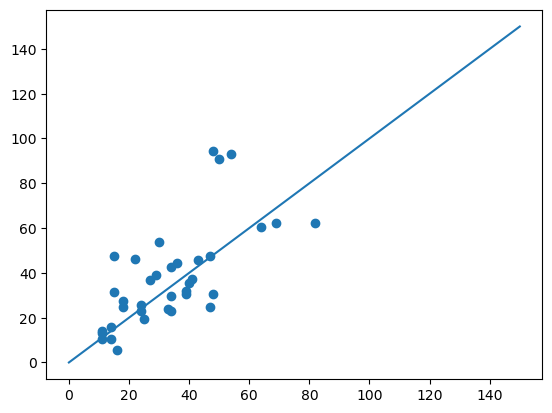

In [458]:
y_pred = model.predict(X_train_test)
#y_pred = y_pred*((y_pred>=0)*1)
plt.scatter(y_train_test, y_pred)
np.mean((y_pred-y_train_test)**2)
plt.plot([0,150],[0,150])
model['lin_model'].coef_


#### Merged Data for Scaled Data
```merged_df[Death_Rate]``` will be $\displaystyle \frac{\# \textup{Maternal Deaths}}{\textup{Female Population}} \times 1,000,000.$


The income categories are scaled by the ```Total``` index which is the total population of the state.

This doesn't inlcude any ```natality_df``` dataframe information, but that can be incorporated easily. I  just don't know that data as well.

In [291]:
scale_income = copy.copy(income_df)
for c in scale_income.columns:
    if not c in ["State","Year","Total"]:
        scale_income[c] = scale_income[c]/scale_income.Total
scale_income = scale_income[scale_income.columns[:-1]]

merged_df = pd.merge(left = maternal_mortality_df, right = scale_income, on = ["Year","State"], how = 'inner')
print(f"Maternal mortality and income data frame has size {merged_df.shape}.")
merged_df = pd.merge(left = merged_df, right = behavior_df[[c for c in behavior_df.columns if not "Absolute" in c]], on =["Year", "State"], how = 'inner' )
print(f'Maternal mortality, income, and behavioral data frame has size {merged_df.shape}')
merged_df["Death_Rate"] = merged_df.Deaths/merged_df.Female_Population*(10**6)

### Change Column Order
all_column_list = list(merged_df.columns)
all_column_list.remove("Female_Population")
all_column_list.remove("Deaths")
all_column_list.remove("Population")
column_list = ["State","Year", "Death_Rate"]
for c in column_list:
    all_column_list.remove(c)
column_list.extend(all_column_list)

merged_df = merged_df[column_list]



Maternal mortality and income data frame has size (293, 7).
Maternal mortality, income, and behavioral data frame has size (267, 12)


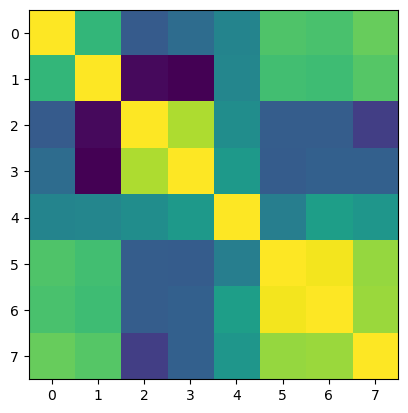

In [292]:
MergeDF_Corr = merged_df[merged_df.columns[2:]].corr(method = 'pearson')
plt.imshow(MergeDF_Corr)


In [293]:
MergeDF_Corr.sort_values("Death_Rate",ascending= False, inplace = True)
print(MergeDF_Corr.Death_Rate.head(20))

Death_Rate                     1.000000
Percent_No_Activity            0.542315
Percent_Obese                  0.459676
Percent_Overweight_or_Obese    0.438087
sub_75k_income                 0.340650
Percent_Overweight            -0.079669
above_150k_income             -0.268725
between_75k_150k_income       -0.396579
Name: Death_Rate, dtype: float64


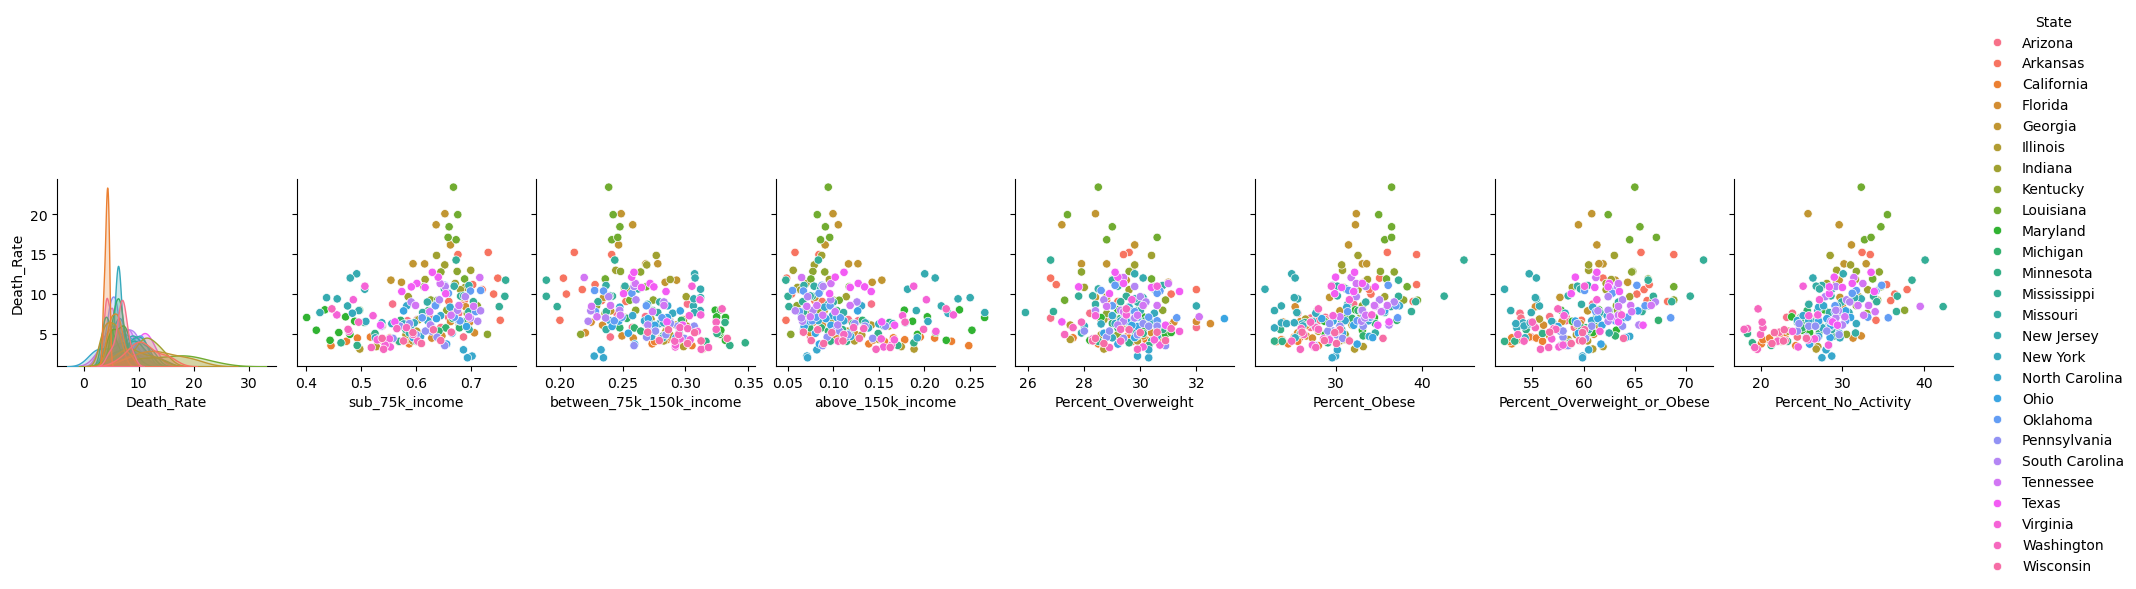

In [294]:
merged_good = merged_df[merged_df.State.isin(list(merged_df.groupby("State").Year.count().reset_index()[merged_df.groupby("State").Year.count().reset_index().Year>=7].State.unique()))]
sns.pairplot(merged_good, hue = "State", y_vars= 'Death_Rate', x_vars = merged_good.columns[2:])

In [275]:
merged_good.head()
y = merged_good.Death_Rate.values
X = merged_good[merged_good.columns[3:]].values
X_train, X_test , y_train, y_test = train_test_split(X,y, shuffle= True, test_size = .2, random_state= 12)
numerical_columns = merged_good.columns[3:]


In [276]:
stand_scaling = StandardScaler()
model = LinearRegression()
X_train_scale = stand_scaling.fit_transform(X_train)

In [277]:
cv_classes = 10
rfecv = RFECV(estimator = model, step = 1, cv = cv_classes)
rfecv.fit(X_train, y_train)
support = rfecv.support_
print(f"Number of features removed is {X_train_scale.shape[1]-np.sum(support*1)}.")
X_train_selected = X_train[:,support]
print(f"Number of remaing features is {X_train_selected.shape[1]}.")
print("\n")
print("The features deleted are:")
for (c,bo) in zip(numerical_columns,support):
    if not bo:
        print("\tFeature "+c+" is deleted.")
print("\n")
print("The features kept are:")
for (c,bo) in zip(numerical_columns,support):
    if bo:
        print("\tFeature "+c+" is kept.")


Number of features removed is 2.
Number of remaing features is 5.


The features deleted are:
	Feature Percent_Obese is deleted.
	Feature Percent_Overweight_or_Obese is deleted.


The features kept are:
	Feature sub_75k_income is kept.
	Feature between_75k_150k_income is kept.
	Feature above_150k_income is kept.
	Feature Percent_Overweight is kept.
	Feature Percent_No_Activity is kept.


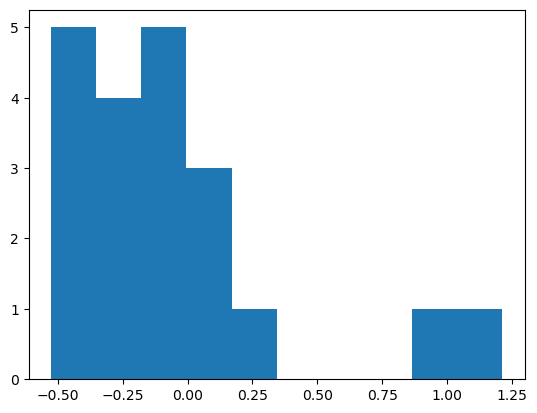

The average error for linear regression is -0.03.
The standard deviation for linear regression is 0.44.


In [279]:
from sklearn.metrics import mean_squared_error
model = Pipeline([("scale", StandardScaler()), ("approx", LinearRegression())])
cv_classes = 20
cv_scores = cross_val_score(estimator=model, X = X_train_selected, y = y_train, cv = cv_classes)

plt.hist(-cv_scores)
plt.show()
print(f"The average error for linear regression is {np.round(-cv_scores.mean(),2)}.")
print(f"The standard deviation for linear regression is {np.round(cv_scores.std(),2)}.")

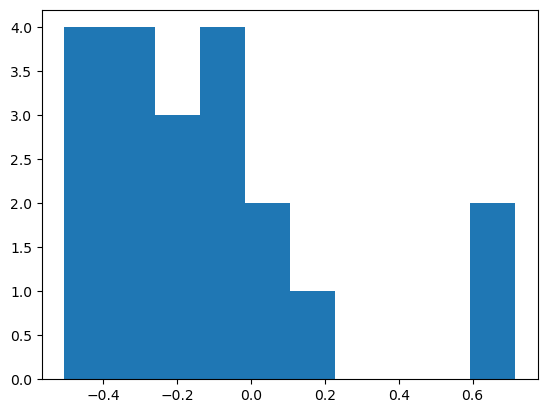

The average error for Poisson regression is -0.12.
The standard deviation for Poisson regression is 0.33.


In [281]:

model = Pipeline([("scale", StandardScaler()), ("approx", PoissonRegressor())])
cv_classes = 20
cv_scores = cross_val_score(estimator=model, X = X_train_selected, y = y_train, cv = cv_classes)

plt.hist(-cv_scores)
plt.show()
print(f"The average error for Poisson regression is {np.round(-cv_scores.mean(),2)}.")
print(f"The standard deviation for Poisson regression is {np.round(cv_scores.std(),2)}.")


c:\Users\david\anaconda3\envs\erdos_spring_2025\Lib\site-packages\sklearn\base.py:1389: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
c:\Users\david\anaconda3\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
c:\Users\david\anaconda3\envs\erdos_spring_2025\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.959e+02, tolerance: 2.223e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn

The average error for Lasso with alpha = 0 is 9.7.
The standard deviation for Lasso with alpha = 0 is 6.14.
The average error for Lasso with alpha = 0.1 is 9.53.
The standard deviation for Lasso with alpha = 0.1 is 6.23.
The average error for Lasso with alpha = 0.5 is 9.89.
The standard deviation for Lasso with alpha = 0.5 is 7.08.
The average error for Lasso with alpha = 1 is 10.56.
The standard deviation for Lasso with alpha = 1 is 7.64.
The average error for Lasso with alpha = 2 is 12.83.
The standard deviation for Lasso with alpha = 2 is 8.65.
The average error for Lasso with alpha = 5 is 12.83.
The standard deviation for Lasso with alpha = 5 is 8.65.


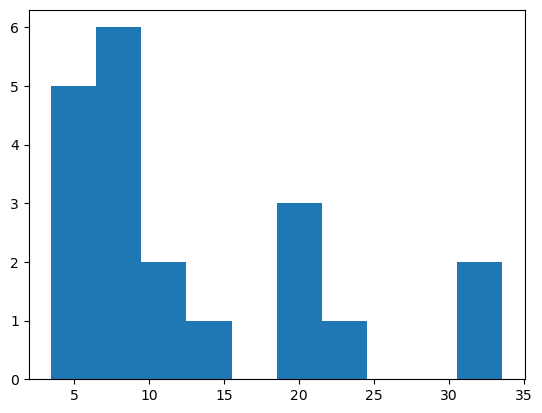

The average error for Lasso regression is 12.83.
The standard deviation for Lasso regression is 8.65.


In [282]:
alpha_choices = [0, 1/10, 1/2, 1, 2, 5]
for alpha in alpha_choices:
    model = model = Pipeline([("scale", StandardScaler()), ("approx",Lasso(max_iter= 50000, alpha = alpha))])
    cv_classes = 20
    cv_scores = cross_val_score(estimator=model, X = X_train_selected, y = y_train, cv = cv_classes, scoring='neg_mean_squared_error')
    print(f"The average error for Lasso with alpha = {np.round(alpha,2)} is {np.round(-cv_scores.mean(),2)}.")
    print(f"The standard deviation for Lasso with alpha = {np.round(alpha,2)} is {np.round(cv_scores.std(),2)}.")
plt.hist(-cv_scores)
plt.show()
print(f"The average error for Lasso regression is {np.round(-cv_scores.mean(),2)}.")
print(f"The standard deviation for Lasso regression is {np.round(cv_scores.std(),2)}.")


The average error for this model is 0.17.


np.float64(12.74551649626735)

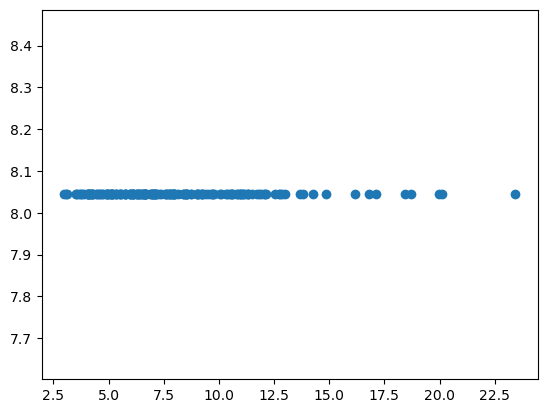

In [290]:
from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
model = Pipeline([                ("transform", FunctionTransformer(lambda x: np.log(1+np.sqrt(x)),validate=True)),
("transform2", PolynomialFeatures(degree = 2)),
                ("stand_scaling", StandardScaler()),
                ("lin_model",Lasso(alpha =3))
            ])

cv_scores = cross_val_score(estimator=model, X = X_train_selected, y = y_train, cv = cv_classes)
print(f"The average error for this model is {np.round(-cv_scores.mean(),2)}.")

model.fit(X_train_selected, y_train)
y_pred = model.predict(X_train_selected)
plt.scatter(y_train, y_pred)
np.mean((y_pred-y_train)**2)